---

## Survival Analysis for Predicting In-Hospital Mortality in ICU Patients
This notebook is dedicated to performing survival analysis on data from the PhysioNet Challenge, specifically focusing on predicting in-hospital mortality risk for patients in Intensive Care Units (ICU). Our approach involves using the Kaplan-Meier estimator, a non-parametric statistic used to estimate the survival function from lifetime data, particularly suitable for handling censored data commonly encountered in healthcare settings

### Approach
We will utilize the Kaplan-Meier method to estimate survival probabilities over time for ICU patients. This method is particularly advantageous in medical research for its ability to handle censored data and provide a visual understanding of survival probabilities over time

### Steps
1. **Dataset Overview**: Introduction to the dataset and key variables for survival analysis
2. **Data Preprocessing**: Preparing the dataset for Kaplan-Meier analysis, including handling of censored data
3. **Kaplan-Meier Estimation**: Understanding and implementing the Kaplan-Meier method to estimate survival probabilities
4. **Survival Curve Plotting**: Visualizing the survival curve to interpret how survival probabilities change over time
5. **Result Interpretation**: Discussing the implications of the survival curve in the context of in-hospital mortality in ICU settings
6. **Additional Analysis**: Exploring further topics in survival analysis such as comparing different patient groups or incorporating additional variables into the analysis

#### The goal of this analysis is not only to estimate in-hospital mortality risk but also to provide a deeper understanding of survival probabilities over time for ICU patients, which is crucial for medical decision-making and patient care planning

---

## 0. Data Ingestion
We will be using the [PhysioNet Challenge 2012 dataset](https://physionet.org/content/challenge-2012/1.0.0/), which contains data from 4000 ICU patients. The dataset is provided in the form of a CSV file, which we will read into a Pandas DataFrame for further analysis.

In [2]:
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
from lifelines import NelsonAalenFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts

from lifelines import CoxPHFitter
from lifelines.utils import concordance_index as cindex
from sklearn.model_selection import train_test_split


In [3]:
ICU_df = pd.read_csv('PhysionetChallenge2012-set-a.csv.gz', compression='gzip')

In [4]:
ICU_df.shape

(4000, 120)

## 1. Dataset Overview: Introduction to the dataset and key variables for survival analysis
We'll be focusing on the following variables for our survival analysis: Survival time, in-hospital mortality, and length of stay in the ICU.

In [5]:
ICU_df[['Survival', 'Length_of_stay', 'In-hospital_death']].sample(10)

,Survival,Length_of_stay,In-hospital_death
3058,-1,7,0
650,-1,10,0
1227,-1,20,0
2085,-1,5,0
2877,-1,35,0
326,-1,15,0
2862,341,8,0
998,-1,6,0
2923,581,21,0
3104,11,12,1


Refer to [PhysioNet Challenge 2012 dataset](https://physionet.org/content/challenge-2012/1.0.0/) for information on the intepretatin of these two columns i.e.

1. **Length of Stay**: How long a patient stayed in the hospital from the time they were admitted to the ICU, includes any time spent in the hospital even after leaving the ICU until they:
    - a) left the hospital
    - b) passed away
2. **Survival**: The number represents how many days a patient lived after being admitted to the ICU. 
    - If a patient died (whether in the hospital or after leaving), "Survival" shows the number of days from ICU admission to their death
    - If a patient did not die, or if there's no record of their death, "Survival" is given a value of -1
3. **In-hospital Mortality**: Whether a patient died in the hospital (1) or not (0). 
    - Serves as the "event indicator", in this case, is death in the hospital.
    - The Kaplan-Meier estimator uses this information to calculate the probability of survival over time, considering both patients who experienced the event (death) and those who did not
    - This is crucial for interpreting the survival curves accurately

Hence:
- If "Survival" is greater than "Length of Stay", it means the patient survived and left the hospital
- If "Survival" equals -1, it also means the patient survived (but we don't know for how long)
- If "Survival" is between 2 and the "Length of Stay" (inclusive), it means the patient died in the hospital

#### Survival > Length of stay  ⇒  Survivor
#### Survival = -1  ⇒  Survivor
#### 2 ≤ Survival ≤ Length of stay  ⇒  In-hospital death

Text(0, 0.5, 'Frequency')

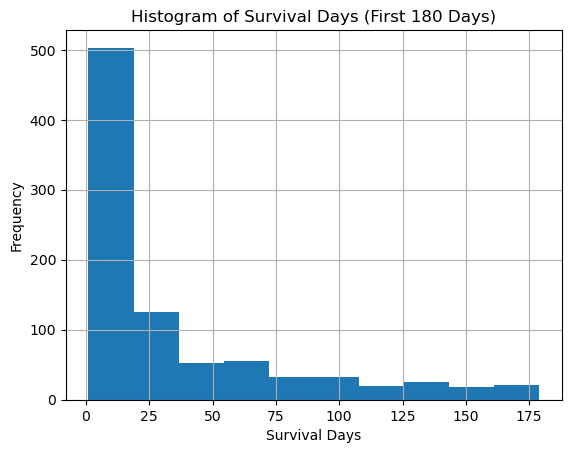

In [25]:
# Destribution of Survival days for Non-Censored Patients
ICU_df.Survival[(ICU_df.Survival<=180) & (ICU_df.Survival>0)].hist();
plt.title('Histogram of Survival Days (First 180 Days)')
plt.xlabel('Survival Days')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

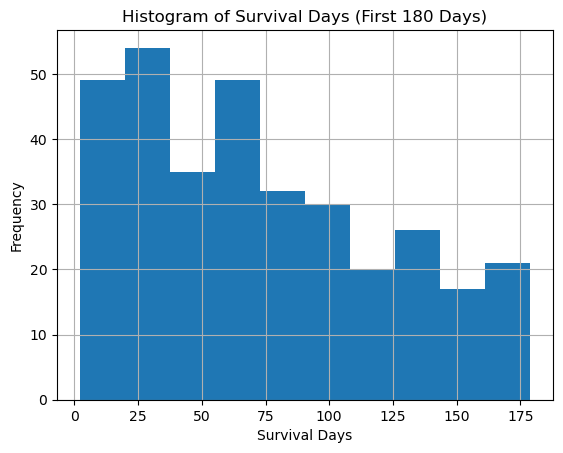

In [29]:
# Destribution of Survival days for Non-Censored Patients and did not die in the hospital
ICU_df.Survival[(ICU_df.Survival<=180) & (ICU_df.Survival>0) & (ICU_df['In-hospital_death']==0)].hist();
plt.title('Histogram of Survival Days (First 180 Days)')
plt.xlabel('Survival Days')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

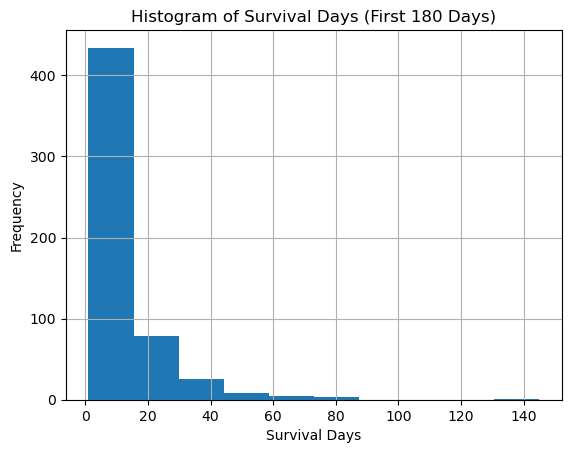

In [31]:
# Destribution of Survival days for Non-Censored Patients and that died in the hospital
ICU_df.Survival[(ICU_df.Survival<=180) & (ICU_df.Survival>0) & (ICU_df['In-hospital_death']==1)].hist();
plt.title('Histogram of Survival Days (First 180 Days)')
plt.xlabel('Survival Days')
plt.ylabel('Frequency')

## 2. Data Preprocessing: Preparing the dataset for Kaplan-Meier analysis, including handling of censored data

1. Handle Censored Data: In the dataset, a 'Survival' value of -1 indicates the patient survived (censored data)
2. Use 'In-hospital_death' as the event indicator, with death as the event of interest
3. Filter Data: Exclude records that are not relevant or incorrectly formatted for survival analysis

In [5]:
# Check data types and if there's any non-numeric values
# ICU_df['Survival'].dtype, ICU_df['In-hospital_death'].dtype, ICU_df['Length_of_stay'].dtype
# ICU_df['Survival'].isnull().sum(), ICU_df['In-hospital_death'].isnull().sum(), ICU_df['Length_of_stay'].isnull().sum()
# ICU_df['Survival'].value_counts()

# 3. Kaplan-Meier Estimation
Implementing the Kaplan-Meier method to estimate survival probabilities over time for the ICU patients

In [3]:
# Creating the Kaplan-Meier object
kmf = KaplanMeierFitter()

# Fitting the data into the model
kmf.fit(durations=ICU_df['Survival'], event_observed=ICU_df['In-hospital_death'])

# Displaying the survival function
kmf.survival_function_


,KM_estimate
timeline,
-1.0,1.000000
0.0,1.000000
1.0,0.982325
2.0,0.944256
3.0,0.909560
...,...
2350.0,0.614522
2386.0,0.614522
2408.0,0.614522


## 4. Survival Curve Plotting: Visualizing the survival curve to interpret how survival probabilities change over time

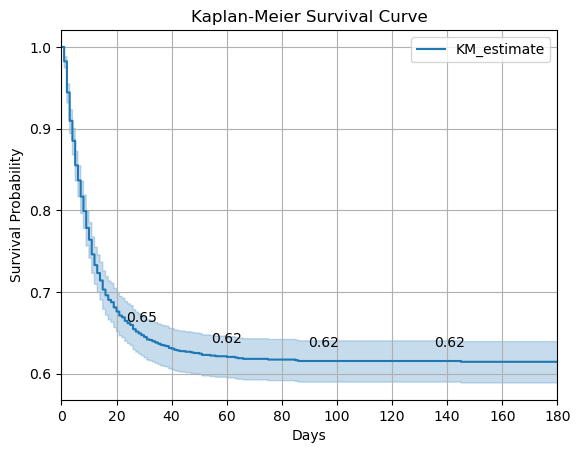

In [7]:
kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curve')
plt.xlabel('Days')
plt.ylabel('Survival Probability')

# Add gridlines
plt.grid(True)

# Zoom in on the first 180 days to see more detail
plt.xlim(0, 180)

# Annotate specific points
for i in range(0, 180, 30):  # Annotate every 30 days
    plt.annotate(f"{kmf.survival_function_.iloc[i, 0]:.2f}",
                 (kmf.survival_function_.index[i], kmf.survival_function_.iloc[i, 0]),
                 textcoords="offset points",  # how to position the text
                 xytext=(0,10),  # distance from text to points (x,y)
                 ha='center')  # horizontal alignment can be left, right or center

plt.show()


## 5. Result Interpretation: Discussing the implications of the survival curve in the context of in-hospital mortality in ICU settings
Interpreingt the Kaplan-Meier survival plot and understand what it indicates about the patient cohort

1. **Early Decline**: What factors might contribute to early mortality in ICU patients e.g. severity of illness, emergency admissions
2. **Plateau Phase**: What factors may help explaining the plateau in the survival curve? e.g. patients with better long-term prognosis
3. **Long-term Survivors**: What does it indicate when the survival probability becomes flat? e.g. patients who survived for a long duration
4. **Censoring**: What's the impact of censored data on the survival estimates, especially towards the end of the study period?
5. **Clinical Implications**: **SO WHAT!?** How these survival probabilities can inform clinical practice, patient counseling, and healthcare policy

## 6. Additional Analysis: Exploring further topics in survival analysis e.g. different patient groups

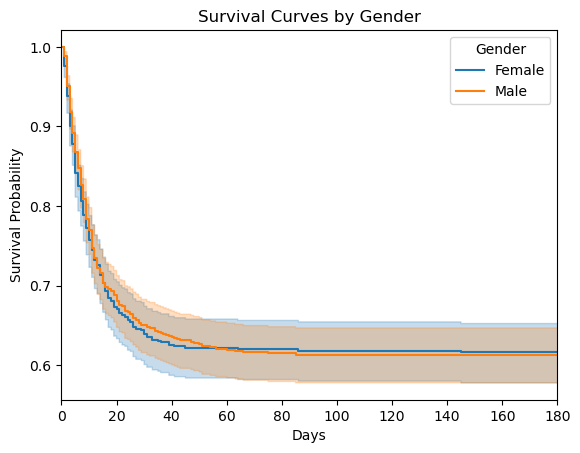

In [8]:
# Plot the survival curves for each gender on the same graph and set the legend labels
ax = plt.subplot(111)

# Zoom in on the first 180 days to see more detail
plt.xlim(0, 180)

# Plot survival curves for each gender
genders = ICU_df['Gender'].unique()
for gender in genders:
    # Selecting data for the specific gender
    data = ICU_df[ICU_df['Gender'] == gender]

    # Check if the group has data
    if not data.empty:
        # Fit the Kaplan-Meier model
        kmf.fit(durations=data['Survival'], event_observed=data['In-hospital_death'])

        # Plot the survival curve with a custom label
        kmf.plot_survival_function(ax=ax, label=('Female' if gender == 0 else 'Male'))

# Enhance the plot with a title and labels
ax.set_title('Survival Curves by Gender')
ax.set_xlabel('Days')
ax.set_ylabel('Survival Probability')

# Correct the legend
ax.legend(title='Gender')
plt.show()


**SAPS-I** Simplified Acute Physiology Score I. It is a scoring system used to assess the severity of disease for patients admitted to an intensive care unit (ICU)

c:\Users\idiazl01\AppData\Local\miniconda3\envs\ICU_predict\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\idiazl01\AppData\Local\miniconda3\envs\ICU_predict\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


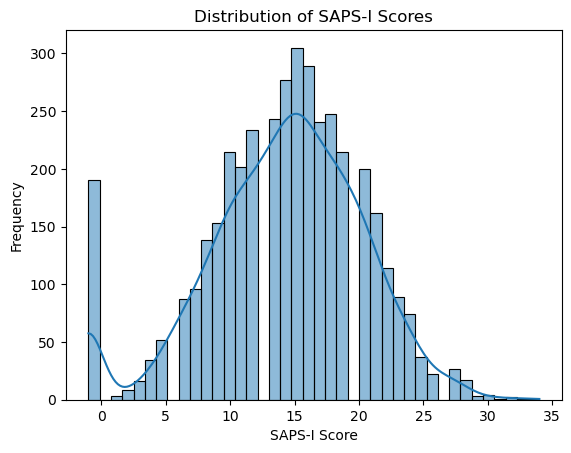

In [9]:
# Visualize the distribution of SAPS-I scores to determine cutoffs for "Low", "Medium", and "High"
sns.histplot(ICU_df['SAPS-I'], kde=True)
plt.title('Distribution of SAPS-I Scores')
plt.xlabel('SAPS-I Score')
plt.ylabel('Frequency')
plt.show()


In [10]:
# Calculate the mean and standard deviation of the SAPS-I scores
saps_mean = ICU_df['SAPS-I'].mean()
saps_std = ICU_df['SAPS-I'].std()

# Define cutoffs using standard deviations from the mean
low_saps_cutoff = saps_mean - saps_std
high_saps_cutoff = saps_mean + saps_std

# Categorize the SAPS-I scores using these cutoffs
ICU_df['SAPS-I_Category'] = pd.cut(ICU_df['SAPS-I'], 
                                    bins=[ICU_df['SAPS-I'].min(), low_saps_cutoff, high_saps_cutoff, ICU_df['SAPS-I'].max()],
                                    labels=['Low', 'Medium', 'High'], 
                                    right=False)

# Output the cutoffs and a few rows of the dataframe to verify the categorization
low_saps_cutoff, high_saps_cutoff, ICU_df[['SAPS-I', 'SAPS-I_Category']].head()


(8.11491597217662,
 20.29208402782338,
    SAPS-I SAPS-I_Category
 0       6             Low
 1      16          Medium
 2      21            High
 3       7             Low
 4      17          Medium)

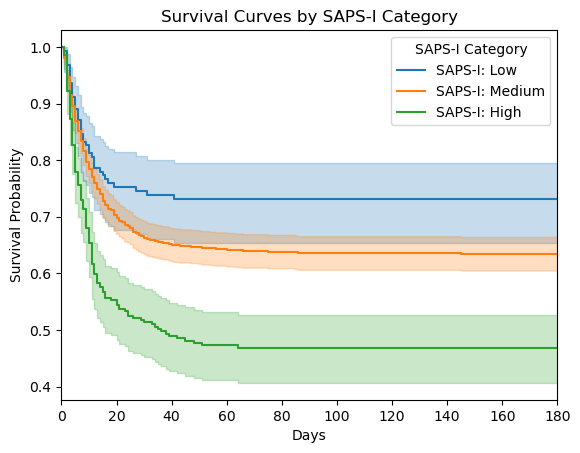

In [11]:
# Plot survival curves for each SAPS-I category
for category in ['Low', 'Medium', 'High']:
    # Selecting data for the specific category
    data = ICU_df[ICU_df['SAPS-I_Category'] == category]

    # Fit the Kaplan-Meier model
    kmf.fit(durations=data['Survival'], event_observed=data['In-hospital_death'], label=f'SAPS-I: {category}')

    # Plot the survival curve
    kmf.plot_survival_function()

# Zoom in on the first 180 days to see more detail
plt.xlim(0, 180)
# Enhance the plot
plt.title('Survival Curves by SAPS-I Category')
plt.xlabel('Days')
plt.ylabel('Survival Probability')
plt.legend(title='SAPS-I Category')
plt.show()


- **CCU** (Critical Care Unit)
- **CSRU** (Cardiac Surgery Recovery Unit)
- **SICU** (Surgical Intensive Care Unit)

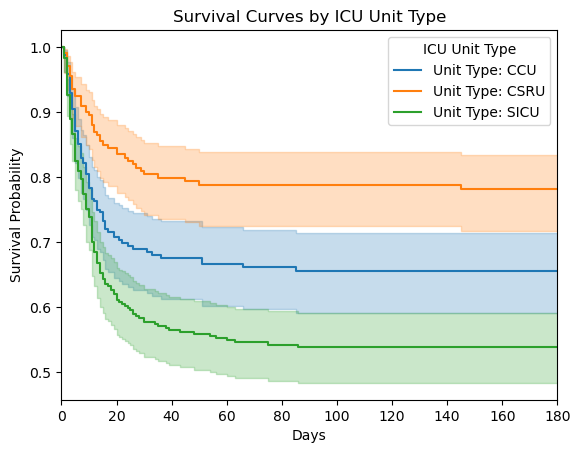

In [12]:
# Define unit types
unit_types = ['CCU', 'CSRU', 'SICU']

# Plot survival curves for each unit type
for unit in unit_types:
    # Selecting data for the specific unit
    data = ICU_df[ICU_df[unit] == 1]  # Assuming a 1 indicates admission to the unit

    # Fit the Kaplan-Meier model
    kmf.fit(durations=data['Survival'], event_observed=data['In-hospital_death'], label=f'Unit Type: {unit}')

    # Plot the survival curve
    kmf.plot_survival_function()

# Zoom in on the first 180 days to see more detail
plt.xlim(0, 180)
# Enhance the plot
plt.title('Survival Curves by ICU Unit Type')
plt.xlabel('Days')
plt.ylabel('Survival Probability')
plt.legend(title='ICU Unit Type')
plt.show()


### 6.1 Other visualization methods for further analysis of the outcomes

6.1.1 **Risk Tables**: This table displays the count of individuals still at risk of the event (death) at certain times during a study. Helping us to further interpret the survival curves, as it shows the sample size over time

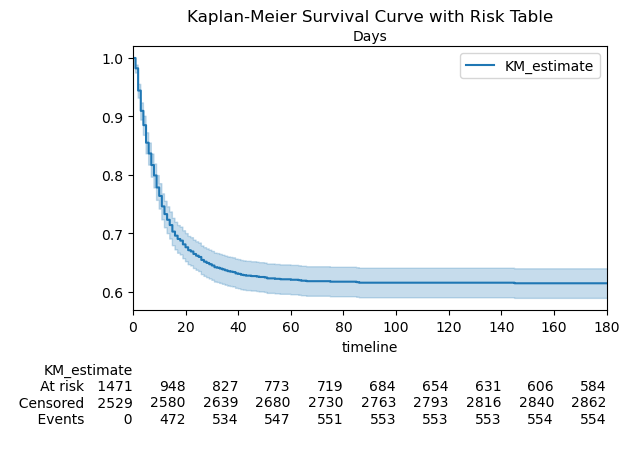

In [4]:
plt.clf()
plt.xlim(0, 180)
# Plot the survival function
ax = kmf.plot_survival_function()

# Add risk table at the bottom of the plot
add_at_risk_counts(kmf, ax=ax)

# Add titles and labels
plt.title('Kaplan-Meier Survival Curve with Risk Table')
plt.xlabel('Days')
plt.ylabel('Survival Probability')

# Display the plot
plt.tight_layout()
plt.show()

6.1.2 **The cumulative hazard rate** show the cumulative incidence of an event (death or discharge) over time. Giving a different perspective to the Kaplan-Meier survival curve, focusing more on the accumulation of events over time

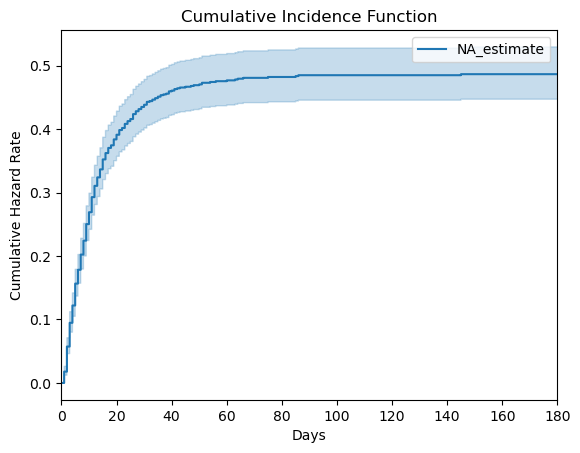

In [15]:
# Create a Nelson-Aalen fitter instance
naf = NelsonAalenFitter()

naf.fit(ICU_df['Survival'], event_observed=ICU_df['In-hospital_death'])

# Plot the Cumulative Incidence Function
naf.plot_cumulative_hazard()
plt.xlim(0, 180)
plt.title('Cumulative Incidence Function')
plt.xlabel('Days')
plt.ylabel('Cumulative Hazard Rate')
plt.show()

6.1.3 **Log-Rank Test:** This statistical test compares the survival distributions of two groups, checking if there's a significant difference in survival times or not

In [16]:
# Separate the data into groups
group1 = ICU_df[ICU_df['Gender'] == 0]  
group2 = ICU_df[ICU_df['Gender'] == 1]

# Perform the Log-Rank Test
results = logrank_test(group1['Survival'], group2['Survival'], 
                       event_observed_A=group1['In-hospital_death'], 
                       event_observed_B=group2['In-hospital_death'])

# Print the test results
results.summary


,test_statistic,p,-log2(p)
0,0.01629,0.89844,0.154507


*"There's (or not) enought evidence to reject the null hypothesis in favour of the alrernative hypothesis"*

# But what if we need to understand the risk of specific indidiuals???